In [1]:
from model_autoencoder import Autoencoder
from dataset import Dataset
import torch
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.metrics import roc_curve, auc, recall_score, accuracy_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from config import *

In [2]:
model = Autoencoder()
model.load_state_dict(torch.load(SAVED_MODEL))

metadata = pd.read_csv(METADATA_FILE)
window_metadata = pd.read_csv(WINDOW_METADATA_FILE)

directories_an = [dir.path for dir in os.scandir(ANNOTATED_PATCHES_DIR) if dir.is_dir()]
directories_cr = [dir.path for dir in os.scandir(CROPPED_PATCHES_DIR) if dir.is_dir()]

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128), antialias=True),
    transforms.Normalize(mean=[0.5], std=[0.5])])

In [4]:
def red_pixels(img):
    img = img.permute(1, 2, 0).detach().numpy()
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_limit = 340
    upper_limit = 20
    count = ((img[:, :, 0] >= lower_limit) | (img[:, :, 0] <= upper_limit)).sum()

    return count

In [6]:
#Llegir dades Annotated per entrenar xgboost per predir proba patches
target_patch = []
ror_train = []
rout_train = []

for dir in directories_an:
    if metadata.loc[metadata["CODI"] == dir.split("/")[-1].split("_")[0], "DENSITAT"].values[0] == "NEGATIVA":
        target_pac_train.append(0)
    else:
        target_pac_train.append(1)
    files = os.listdir(dir)
    if len(files) == 0:
        continue
    for file in files:
        if window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == -1:
            target_patch.append(0)
        else:
            target_patch.append(1)
        img = read_image(os.path.join(dir, file))[:-1,:,:]
        img = img.to(torch.float32)
        img = img/255
        img = transform(img)
        model.eval()
        img_processed = model(img, "autoencoder")
        red_pixels_original = red_pixels(img)
        red_pixels_output = red_pixels(img_processed)
        ror_train.append(red_pixels_original)
        rout_train.append(red_pixels_output)
        test = pd.DataFrame({"Red_Original": [red_pixels_original], "Red_Output": [red_pixels_output]})

/tmp/ipykernel_1231448/2707539380.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if window_metadata.loc[window_metadata["ID"] == str(dir.split("/")[-1])+"."+file[:-4], "Presence"].values == -1:


In [7]:
df_train = pd.DataFrame({"Red_Original": ror_train, "Red_Output": rout_train, "Target": target_patch})

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [12]:
#X_train = df_train.drop(columns=['Target'])
#y_train = df_train['Target']
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['Target']), df_train['Target'], test_size=0.2, random_state=42)

In [13]:
sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = 1
sample_weights[y_train == 1] = (len(y_train)-sum(y_train))/sum(y_train)

In [14]:
# Create a GradientBoostingClassifier for binary classification
gb_classifier = GradientBoostingClassifier(
    n_estimators=100,           # Number of boosting rounds (trees to build)
    learning_rate=0.1,          # Step size shrinkage to prevent overfitting
    max_depth=3,                # Maximum depth of a tree
    random_state=42,             # Seed for reproducibility
)

In [15]:
# Train the classifier on the training data
gb_classifier.fit(X_train, y_train, sample_weight=sample_weights)

GradientBoostingClassifier(random_state=42)

In [16]:
y_pred = gb_classifier.predict_proba(X_test)

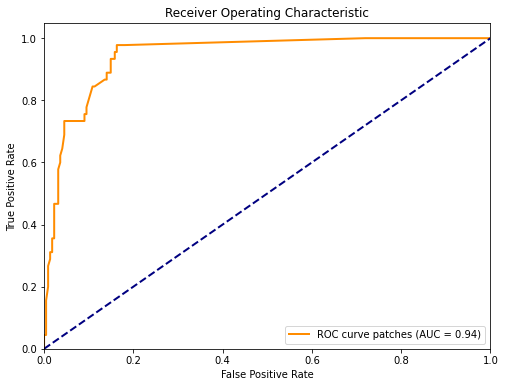

In [17]:
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred[:,1])
roc_auc2 = auc(fpr2, tpr2)
plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label=f'ROC curve patches (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig(f"{PLOT_LOSS_DIR}ROCcurve2.png")

In [18]:
J2 = tpr2 - fpr2
best_threshold2 = thresholds2[np.argmax(J2)]
print(best_threshold2)

0.132848738225855


In [19]:
predicted_labels2 = [0 if p < best_threshold2 else 1 for p in y_pred[:,1]]

In [20]:
# Calculate the confusion matrix
confusion_matrix2 = metrics.confusion_matrix(y_test, predicted_labels2)

# Print the confusion matrix
print("Confusion matrix patches:")
print(confusion_matrix2)

Confusion matrix patches:
[[185  36]
 [  1  44]]


In [21]:
recall_score(y_test, predicted_labels2), accuracy_score(y_test, predicted_labels2)

(0.9777777777777777, 0.8609022556390977)

In [22]:
p = pd.DataFrame({"Red_Original": [7], "Red_Output": [4]})
gb_classifier.predict_proba(p)

array([[0.76861083, 0.23138917]])

In [117]:
#Llegir dades Crop per predir patches amb xgboost previament entrenat
target_pac = []
ror_test = []
rout_test = []
props = []

for dir in directories_cr[50:60]:
    if metadata.loc[metadata["CODI"] == dir.split("/")[-1].split("_")[0], "DENSITAT"].values[0] == "NEGATIVA":
        target_pac.append(0)
    else:
        target_pac.append(1)
    files = os.listdir(dir)
    if len(files) == 0:
        continue
    pred_patch = []
    for file in files:
        img = read_image(os.path.join(dir, file))[:-1,:,:]
        img = img.to(torch.float32)
        img = img/255
        img = transform(img)
        model.eval()
        img_processed = model(img, "autoencoder")
        red_pixels_original = red_pixels(img)
        red_pixels_output = red_pixels(img_processed)
        test = pd.DataFrame({"Red_Original": [red_pixels_original], "Red_Output": [red_pixels_output]})
        pred = gb_classifier.predict_proba(test)
        if pred[:,1] >= best_threshold2:
            pred_patch.append(1)
        else:
            pred_patch.append(0)
    props.append(sum(pred_patch)/len(files))
        


In [118]:
final_results = pd.DataFrame({"Target": target_pac, "Prop": props})

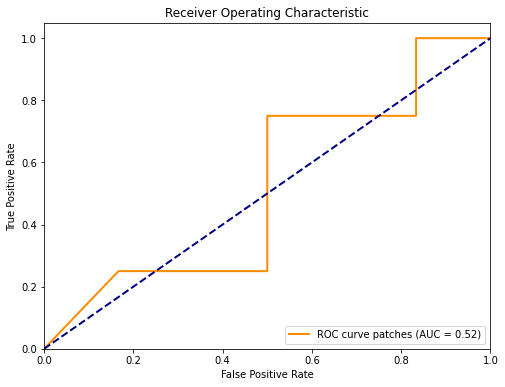

In [119]:
fpr2, tpr2, thresholds2 = roc_curve(final_results['Target'], final_results['Prop'])
roc_auc2 = auc(fpr2, tpr2)
plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label=f'ROC curve patches (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig(f"{PLOT_LOSS_DIR}ROCcurve2.png")

In [120]:
final_results

,Target,Prop
0,0,0.996500
1,0,0.512472
2,0,1.000000
3,1,1.000000
4,0,0.999407
5,1,0.677918
6,0,0.431639
7,1,0.665079
8,1,0.434515
9,0,0.509398


In [121]:
J2 = tpr2 - fpr2
best_threshold2 = thresholds2[np.argmax(J2)]
print(best_threshold2)

0.6650786088613626


In [122]:
predicted_labels2 = [0 if p < best_threshold2 else 1 for p in final_results['Prop']]

In [123]:
# Calculate the confusion matrix
confusion_matrix2 = metrics.confusion_matrix(final_results['Target'], predicted_labels2)

# Print the confusion matrix
print("Confusion matrix patches:")
print(confusion_matrix2)

Confusion matrix patches:
[[3 3]
 [1 3]]


In [124]:
recall_score(final_results['Target'], predicted_labels2), accuracy_score(final_results['Target'], predicted_labels2)

(0.75, 0.6)